<a href="https://colab.research.google.com/github/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/blob/homogen-classification-GCN-Mk.-2/Diplomska_naloga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this model, the data surrounds N number of teams, where a team with a lower index always wins.

The data is stored in a Heterogeneus graph.
A node is a team and it's feature is it's past win/loss ratio.
An edge represents a match. For each match there are 2 edges. It represents the result, from the originating node teams point of view. Meaning that if the number is negative, they lost. The absolute value is the difference in gols. This value is also used as a weight for the edges during learning.

To predict the result, we use a GCN evalueate all teams, concatinate these evaluations in acordance with the edge we are trying to predict (originating node team is first) and then do a linear regression to get a single value, which is the result.

# Setup

## Download whl-s and requirements

In [1]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/refs/heads/main/requirements.txt", "requirements.txt")

('requirements.txt', <http.client.HTTPMessage at 0x7dbb1e19eef0>)

## pip

In [2]:
!sudo apt-get install libcairo2-dev pkg-config python3-dev
!pip install --upgrade pip
!pip install --force-reinstall --no-cache-dir pycairo

!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.5/661.5 kB 56.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycairo: filename=pycairo-1.27.0-cp310-cp310-linux_x86_64.whl size=128157 sha256=8608cc9f4c06e2f2cecbab42a0dcc0941f8917d91b335890d5b22cdcc06ec28e
  Stored in directory: /tmp/pip-ephem-wheel-cache-5_pxkufs/wheel

# Imports

In [3]:
import json
import networkx as nx
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from torch_geometric import nn, sampler
from torch_geometric.data import HeteroData, Data
from torch_geometric import transforms as T
from torch_geometric import loader
from torcheval import metrics as M
from torcheval.metrics import R2Score, MeanSquaredError
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
%matplotlib inline

# Data definition

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

win_value = 1.0
loss_value = -1.0
tie_value = (win_value + loss_value)/2

numTrainMatchCycles = 7
numValMatchCycles = 3
numOfTeams = 100
cycleSize = int((numOfTeams*(numOfTeams - 1))/2)

cycle = [
    [],
    []
]
result = []

for i in range(numOfTeams):
  for j in range(i+1, numOfTeams):
    cycle[0].append(i)
    cycle[0].append(j)
    result.append(j - i)
    cycle[1].append(j)
    cycle[1].append(i)
    result.append(i - j)

# Learning

In [5]:
epochs = 1000

lr = 0.01
dropout_p = 0.0
Diff = True
Tie = True
crit = torch.nn.MSELoss()

# Data: team A always wins

In [6]:
data = Data()
data.x = torch.Tensor(
    [[(numOfTeams - 1 - i)/(numOfTeams - 1)] for i in range(numOfTeams)]
)
data.edge_index = torch.Tensor(
    [cycle[0]*(numTrainMatchCycles + numValMatchCycles),
     cycle[1]*(numTrainMatchCycles + numValMatchCycles)]
).type(torch.long)
data.edge_attr = torch.Tensor(
    [[win_value, loss_value]*cycleSize*(numTrainMatchCycles + numValMatchCycles)]
)
data.edge_weight = torch.abs(torch.Tensor(
    result*(numTrainMatchCycles + numValMatchCycles)
))

data.train_mask = torch.Tensor(
    [[True]*2*cycleSize*numTrainMatchCycles + [False]*2*cycleSize*numValMatchCycles]
).type(torch.bool)
data.val_mask = torch.Tensor(
    [[False]*2*cycleSize*numTrainMatchCycles + [True]*2*cycleSize*numValMatchCycles]
).type(torch.bool)

In [7]:
def plotLoss(loss_data: list[float]):
  plt.plot(range(len(loss_data)), loss_data)
  plt.show()

# Model

In [8]:
class model(torch.nn.Module):
  def __init__(self, channels: list[int], device: str='cpu', dropout: float=0.0):
    assert len(channels) >= 2

    super().__init__()

    self.device = device
    self.dropout = dropout

    self.gcn = torch.nn.ModuleList()
    for i in range(len(channels) - 1):
      self.gcn.append(nn.GCNConv(channels[i], channels[i+1], add_self_loops=False))
    self.gcn.to(self.device)

    self.lin = torch.nn.Linear(channels[-1]*2, 1).to(self.device)

  def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_weight: torch.Tensor) -> torch.Tensor:
    # move data to device
    x = x.to(self.device)
    edge_index = edge_index.to(self.device)
    edge_weight = edge_weight.to(self.device)

    # calculate values for each team
    for module in self.gcn:
      x = module(x, edge_index, edge_weight)
      x = x.relu()
      x = F.dropout(x, p=self.dropout, training=self.training)

    # create match vectors by combining teams that played
    x_1st = x[edge_index[0]]
    x_2nd = x[edge_index[1]]
    lin_input = torch.cat((x_1st, x_2nd), dim=1)

    # calculate result from match vector
    x = self.lin(lin_input)

    return x.T

# Learn

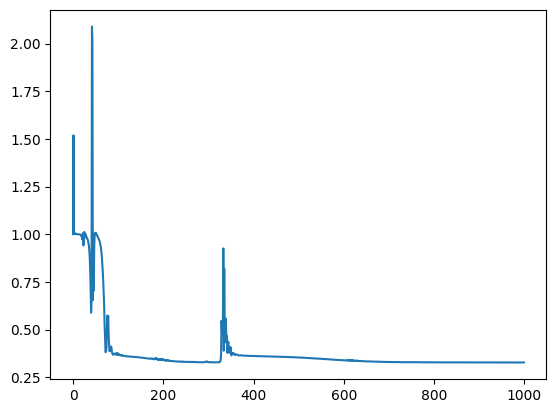

In [9]:
gcn = model([1] + [4*numOfTeams]*5 + [2*numOfTeams], device=device, dropout=dropout_p)
gcn.to(device)
optimizer = torch.optim.Adam(gcn.parameters(), lr=lr)

loss_values = []

for epoch in range(epochs):
  # prepare model for training
  gcn.train()
  optimizer.zero_grad()

  # prepare train data
  train_mask = torch.reshape(data.train_mask, (-1,))
  x = data.x
  edge_index = data.edge_index[:, train_mask]
  edge_weight = data.edge_weight[train_mask]

  # train
  pred = gcn(x, edge_index, edge_weight).to(device)

  # prepare validation data
  ground_truth = data.edge_attr[:, train_mask].to(device)
  ground_truth.requires_grad = True

  # calculate loss
  loss = crit(pred, ground_truth)
  loss_values.append(loss.item())
  loss.backward()
  optimizer.step()

# draw loss
plotLoss(loss_values)

# Evaluate

In [10]:
gcn.eval()

val_mask = torch.reshape(data.val_mask, (-1,))
x = data.x
edge_index = data.edge_index[:, val_mask]
edge_weight = data.edge_weight[val_mask]

pred = gcn(x, edge_index, edge_weight).to(device).T
class_pred = (torch.where(pred >= tie_value, win_value, loss_value) + 1)/2

ground_truth = data.edge_attr[:, val_mask].to(device).T
ground_truth.requires_grad = True
class_ground_truth = (ground_truth + 1)/2

R2 = M.R2Score()
R2.to(device)
R2.update(pred, ground_truth)
print(f"R2: {R2.compute()}")

MSE = M.MeanSquaredError()
MSE.to(device)
MSE.update(pred, ground_truth)
print(f"MSE: {MSE.compute()}")

BiAcc = M.BinaryAccuracy()
BiAcc.to(device)
BiAcc.update(torch.reshape(class_pred, (-1,)), torch.reshape(class_ground_truth, (-1,)))
print(f"BiAcc: {BiAcc.compute()}")

R2: 0.6727864742279053
MSE: 0.3272135555744171
BiAcc: 1.0
